# ARIMA

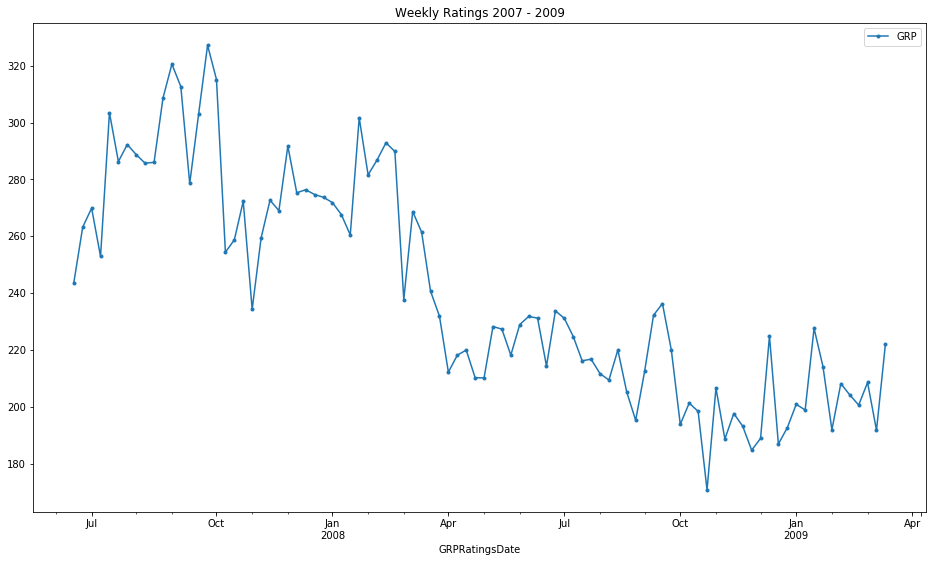

,GRP
GRPRatingsDate,
2009-02-15,204.20
2009-02-22,200.61
2009-03-01,208.56
2009-03-08,191.74
2009-03-15,222.07


In [33]:
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose
import os
import matplotlib
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np
import math
import numpy as np
import statsmodels.api as sm
import itertools
import sys
from pyramid.arima import auto_arima

def mean_absolute_percentage_error(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100


os.chdir('/Users/pierlim/PycharmProjects/IndianTV')
df = pd.read_csv("./data/ActualRatings_weeklyGRP.csv")
df = df.drop(df.columns[2], axis=1)
split_str = df['GRPRatingsDate'].str.split('(')
df['GRPRatingsDate'] = split_str.str[0]
df['GRPRatingsDate'] = pd.to_datetime(df['GRPRatingsDate'])

df = df.set_index('GRPRatingsDate')
df.plot(style='.-', figsize=(16, 9))
plt.title('Weekly Ratings 2007 - 2009')
plt.show()
df.tail()

In [34]:
# log transform
#df = df['GRP'].apply(np.log)

# Get train test
df_train = df[:'2008-10-26']
print(df_train.tail())
print(df_train.shape)

df_test = df['2008-11-1':]
print(df_test.head())
print(df_test.shape)


                   GRP
GRPRatingsDate        
2008-09-28      219.91
2008-10-05      193.84
2008-10-12      201.30
2008-10-19      198.40
2008-10-26      170.74
(72, 1)
                   GRP
GRPRatingsDate        
2008-11-02      206.61
2008-11-09      188.68
2008-11-16      197.64
2008-11-23      193.16
2008-11-30      184.74
(20, 1)


In [35]:
print(df)


                   GRP
GRPRatingsDate        
2007-06-17      243.60
2007-06-24      263.19
2007-07-01      269.89
2007-07-08      252.88
2007-07-15      303.46
2007-07-22      286.29
2007-07-29      292.28
2007-08-05      288.72
2007-08-12      285.70
2007-08-19      286.01
2007-08-26      308.59
2007-09-02      320.57
2007-09-09      312.67
2007-09-16      278.58
2007-09-23      303.06
2007-09-30      327.22
2007-10-07      315.14
2007-10-14      254.39
2007-10-21      258.73
2007-10-28      272.35
2007-11-04      234.26
2007-11-11      259.35
2007-11-18      272.67
2007-11-25      269.03
2007-12-02      291.72
2007-12-09      275.29
2007-12-16      276.38
2007-12-23      274.68
2007-12-30      273.70
2008-01-06      271.84
...                ...
2008-08-24      205.17
2008-08-31      195.25
2008-09-07      212.45
2008-09-14      232.21
2008-09-21      236.31
2008-09-28      219.91
2008-10-05      193.84
2008-10-12      201.30
2008-10-19      198.40
2008-10-26      170.74
2008-11-02 

## Auto-arima

In [37]:
print(df_train.head())
stepwise_fit = auto_arima(df_train, start_p=1, start_q=1, max_p=3, max_q=3, m=12,
                          start_P=0, seasonal=True, d=1, D=1, trace=True,
                          error_action='ignore',  # don't want to know if an order does not work
                          suppress_warnings=True,  # don't want convergence warnings
                          stepwise=True, n_fits=100)  # set to stepwise

print(stepwise_fit.summary())


                   GRP
GRPRatingsDate        
2007-06-17      243.60
2007-06-24      263.19
2007-07-01      269.89
2007-07-08      252.88
2007-07-15      303.46
Fit ARIMA: order=(1, 1, 1) seasonal_order=(0, 1, 1, 12); AIC=539.528, BIC=549.916, Fit time=0.500 seconds
Fit ARIMA: order=(0, 1, 0) seasonal_order=(0, 1, 0, 12); AIC=560.434, BIC=564.589, Fit time=0.014 seconds
Fit ARIMA: order=(1, 1, 0) seasonal_order=(1, 1, 0, 12); AIC=545.762, BIC=554.072, Fit time=0.186 seconds
Fit ARIMA: order=(0, 1, 1) seasonal_order=(0, 1, 1, 12); AIC=538.740, BIC=547.050, Fit time=0.309 seconds
Fit ARIMA: order=(0, 1, 1) seasonal_order=(1, 1, 1, 12); AIC=540.685, BIC=551.073, Fit time=0.531 seconds
Fit ARIMA: order=(0, 1, 1) seasonal_order=(0, 1, 0, 12); AIC=556.461, BIC=562.694, Fit time=0.070 seconds
Fit ARIMA: order=(0, 1, 1) seasonal_order=(0, 1, 2, 12); AIC=nan, BIC=nan, Fit time=nan seconds
Fit ARIMA: order=(0, 1, 1) seasonal_order=(1, 1, 2, 12); AIC=nan, BIC=nan, Fit time=nan seconds
Fit ARIMA: 

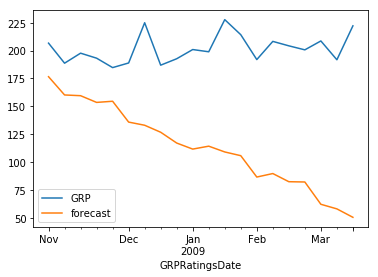

In [38]:

future_forecast = stepwise_fit.predict(n_periods=20)
df_forecast = pd.DataFrame(future_forecast, index=df_test.index)
df_forecast = df_forecast.rename(columns={ df_forecast.columns[0]: "forecast" })
pd.concat([df_test, df_forecast], axis=1).plot()

In [39]:
df_forecast.head()

,forecast
GRPRatingsDate,
2008-11-02,176.603239
2008-11-09,160.282627
2008-11-16,159.621457
2008-11-23,153.621689
2008-11-30,154.653619


In [40]:
mae = mean_absolute_error(df_test['GRP'], df_forecast['forecast'])
mse = mean_squared_error(df_test['GRP'], df_forecast['forecast'])
print('Prediction quality: {:.2f} MSE ({:.2f} RMSE),  ({:.2f} MAE)'.format(mse, math.sqrt(mse), mae))
mape = mean_absolute_percentage_error(df_test['GRP'], df_forecast['forecast'])
print('Prediction quality: {:.2f}% MAPE '.format(mape))

Prediction quality: 9444.77 MSE (97.18 RMSE),  (87.94 MAE)
Prediction quality: 43.06% MAPE 


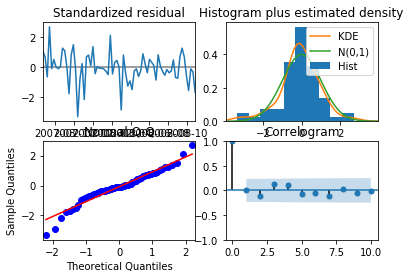

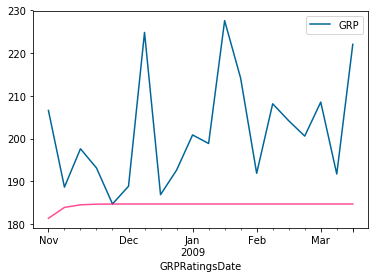

In [135]:

df_train.index = pd.DatetimeIndex(df_train.index.values,
                               freq=df_train.index.inferred_freq)

test_model = sm.tsa.statespace.SARIMAX(df_train, order=(1,1,1),
                                       enforce_stationarity=True, enforce_invertibility=False)
results = test_model.fit()
results.plot_diagnostics()
pred = results.get_prediction(start=pd.to_datetime('2008-11-02'), end=pd.to_datetime('2009-03-15 '), dynamic=True)
pred_ci = pred.conf_int()
ax = df_test['2008-11-02':].plot(label='Observed',color='#006699');
pred.predicted_mean.plot(ax=ax, label='One-step Ahead Prediction', alpha=.7, color='#ff0066')

Observation : There is still some seasonality observed in the standardized residual. 

In [136]:
pred.predicted_mean

2008-11-02    181.380512
2008-11-09    183.929893
2008-11-16    184.540704
2008-11-23    184.687049
2008-11-30    184.722113
2008-12-07    184.730514
2008-12-14    184.732526
2008-12-21    184.733009
2008-12-28    184.733124
2009-01-04    184.733152
2009-01-11    184.733158
2009-01-18    184.733160
2009-01-25    184.733160
2009-02-01    184.733160
2009-02-08    184.733160
2009-02-15    184.733160
2009-02-22    184.733160
2009-03-01    184.733160
2009-03-08    184.733160
2009-03-15    184.733160
Freq: W-SUN, dtype: float64

In [137]:
mae = mean_absolute_error(df_test['GRP'], pred.predicted_mean)
mse = mean_squared_error(df_test['GRP'], pred.predicted_mean)
print('Prediction quality: {:.2f} MSE ({:.2f} RMSE),  ({:.2f} MAE)'.format(mse, math.sqrt(mse), mae))
mape = mean_absolute_percentage_error(df_test['GRP'], pred.predicted_mean)
print('Prediction quality: {:.2f}% MAPE '.format(mape))

Prediction quality: 450.19 MSE (21.22 RMSE),  (17.13 MAE)
Prediction quality: 8.16% MAPE 
